# TIME SERIES ANALYSIS

# Goal: Find outliers, trends and periodicity in the MTA turnstyle data
    

## DATA:
MTA subway fares. It is a complete dataset of
rides logged by card swipes for 600 Manhattan stations.

The data was organized  by Sina Kashuk at CUSP.

It contains 23 different subway card types 
(e.g. monthly pass, daily pass, Act for Disability pass…) as follows:


# Task 4:
**Several stations show a prominent annual periodicity. Identify the 4 **stations** (indentify them by the index of their location in the data cube) that show the most prominent periodic trend on an annual period (52 weeks). (Can you figure out what the periodic peak in rides is due to?)**


# Task 5: Extra Credit
**Cluster the time series, i.e. identify groups of time series that look similar among each other, using the features you engineered:**
- are there distinct clusters?
- do they reflect the card type or station? 

To do this correctly you should whiten the data: each of your 4 features (column if you think about this as a table) should be standardized: 
subtract the mean for taht feature across the sample for each feature and divide the resulting feature vectore by its standard deviation

feature = (feature - feature.mean() ) / feature.std()

each "feature" vectors that results from the operation above should be 7667 long (or whatever the number of clean observcations you were left with)

Note: if you wanted to cluster on all the time stamps, like you build the second model last week, you should standardize each observation (row) instead: 

observation = (observation -observation.mean()) / observation.std()
each of these "observation" vectors should be 194 long (or whatever the number of clean observcations you were left with)


Populating the interactive namespace from numpy and matplotlib


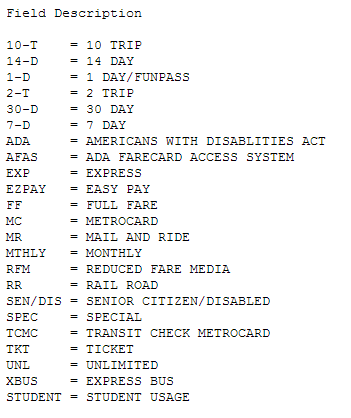

In [1]:
from __future__ import print_function, division
import pylab as pl
import numpy as np
import pandas as pd

from sklearn.ensemble  import RandomForestClassifier as rfc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import statsmodels.api as sm

%pylab inline

from IPython.display import Image
from IPython.display import clear_output
pl.rcParams['font.size'] = 20
Image(filename = "Ridetypes.png")

This is the information I recieved about the data: "each time series (per station, per ticket type) contains
the number of swipes per week for 194 weeks 
from 05/19/2010 to 02/19/2014. "

The data are available to you as a python data cube here:

you can load it as 

np.load(“MTA_Fare.npy") and 


you will end up with a python numpy array of 
shape (600,23,194)

** note that the missing values are inputted as -1**

if you want to do things like algebra (summing time series for example) you need to take care of that! if you replace the -1 entries with NaN remember to use functions that can deal with nans:
np.nanmean
np.nansum...

# HINTS: 

## notes and hints: 

   1) you could coerce the data into a pandas dataframe, but the data is truly a "datacube": a 3D dataset, and flattening it into a pandas dataframe will make it far more difficult to manipulate. I strongly recommand you keep it as a numpy array
    
   2) note that the missing values are inputted as -1. if you want to do things like algebra (summing time series for example) you need to take care of that. If you replace the -1 entries with NaN, you may need to use functions that explicitly know how to deal with NaN: for example, to sum use the np.nansum etc
```
np.nanmean(mtarides)
np.nansum(mtarides)
```
as opposed to just 
```
np.mean(mtarides)
np.sum(mtarides)
```
 
## There are 600 stations, 23 card types. The trick to do this homework succesfully is to "collaps" (by averaging, or summing, depending on the question) the appropriate dimension in different parts of the homework: when you need to work at the station level (if I ask "which station is the one that..."), collaps the card type, when you need to work on the card type, collapse the stations. 

When I ask you "which station ...", you can sum or average over the ridership types for all station and reduce your data by a factor 23. When I ask you "which rideship type ..." you can sum or average over the stations and reduce your data by a factor 600! (or even better you could take a weighted average - *np.average(....weight=...)* -. The sum and average functions take an *axis* argument, which allows you to control which axis of the cube gets averaged. The dimension of the resulting object will allow you to check that you averaged over the right axis.


# Possibly useful functions

You are already familiar with and have already used  most of the functions I needed to perform this exercise. Here are some reminders and on few functions and methods that you may not have encountered yet which may be useful. You do not have to use them: there are many ways to do things and you do not have to solve this problem like I did, but here they are in case you need some help:

* the numpy function np.where() returns the index where a condition is true. It is slow and inefficient but very intuitive and convenient


* the nupy functions np.nansum(), np.sum(), np.nanmean() etc take an array and the axis along which to sum as inputs. If you want to sum over stations, or over rides, you can use these passing the appropriate axis number: axis=1 axis=2...


*  the array methods 
```
np.array.flatten()
np.array.reshape()
```
     allow you to manipulate the shape of an array, for example if you want to run analysis on each individual time series, each station and each ridership type, which I recommand if you want to work on clustering for extra credit (resulting into 600*23=13800 time series) you can flatten the array as
     
```
mtaarray.flatten()
```

    which returns the flatten array:

```
mtaRides = np.load("MTA_Fare.npy")

mtaRides.shape
Out[10]: (600, 23, 194)

mtaRides.flatten().shape
Out[11]: (2677200,)
````

# read in data as instructed above

In [2]:
mta = np.load("MTA_Fare.npy")
mta.shape

(600, 23, 194)

In [3]:
print ("MTA array shape:", mta.shape)
print ("MTA array shape summed over all ride types:", np.nansum(mta,axis=1).shape)

MTA array shape: (600, 23, 194)
MTA array shape summed over all ride types: (600, 194)


create a "ride types" list based on the metadata I was given

In [4]:
#ridership type list
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])
print("number of ride types", len(ridetype))

number of ride types 23


You need to create a date range to plot properly. 
After that I create a date range (for example with pd.date_range())
in a log plot to enhance the visibility along the y axis (np.log10(weightedrides[i]))
all time series, each station each ride type, look like this (pretty ugly)

In [5]:
Rides_n=mta.reshape(13800, 194)

In [6]:
station_data = np.nansum(mta,axis=1)
station_data.shape

(600, 194)

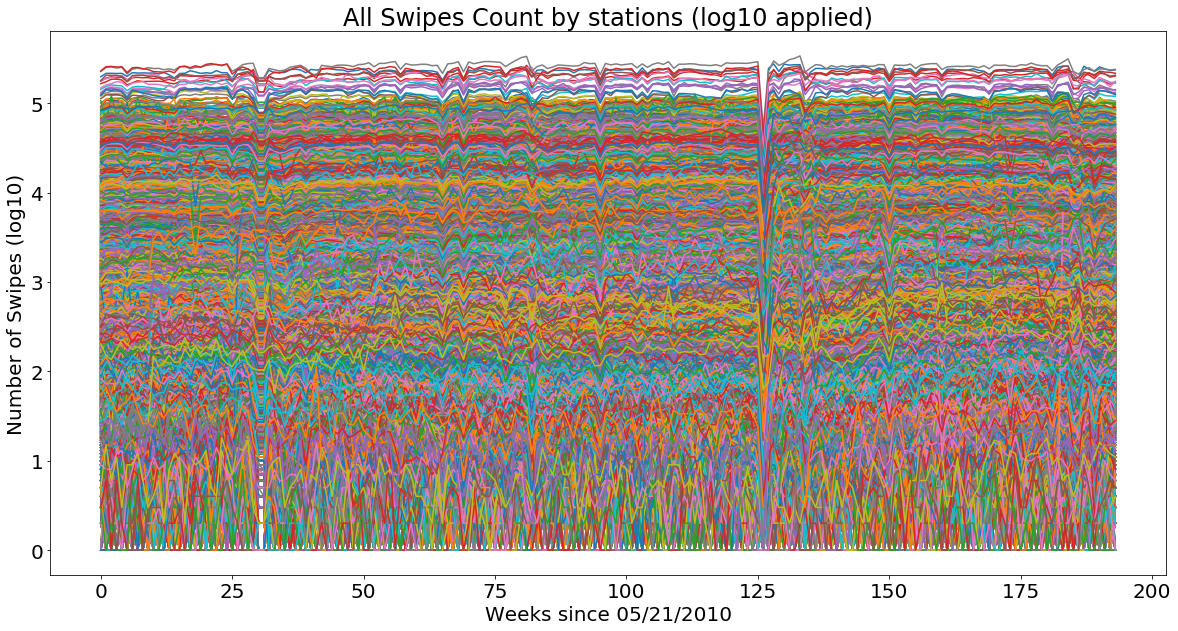

In [7]:
# plot the data in natural space
# then plot the  data in log space (may take a while to plot because of the very inefficient double for loop - 
# the counter needs to get to 23)
pl.figure(figsize=(20,10))
pl.plot(np.log10(Rides_n).T)
pl.title("All Swipes Count by stations (log10 applied)")
pl.xlabel("Weeks since 05/21/2010")
pl.ylabel("Number of Swipes (log10)")


#### Figure 2: time series for all ride types and all stations in semi-log space

In [8]:
station_data_df = pd.DataFrame(station_data)
station_data_dft = station_data_df.T
station_data_dft.shape[0], station_data_dft.shape[1]

(194, 600)

In [9]:
station_data_dft.head()

,0,1,2,3,4,5,6,7,8,9,...,590,591,592,593,594,595,596,597,598,599
0,126877,37305,6605,16377,18563,19986,12448,11090,10481,147186,...,-23,-23,-23,-23,-23,-23,-23,-23,-23,-23
1,149476,46463,6880,17407,19902,20624,13643,11658,11029,154825,...,-23,-23,-23,-23,-23,-23,-23,-23,-23,-23
2,152382,49358,7228,17594,19947,21224,13718,12036,10880,155957,...,-23,-23,-23,-23,-23,-23,-23,-23,-23,-23
3,160174,44848,5730,14241,16075,17411,11459,9808,9122,154913,...,-23,-23,-23,-23,-23,-23,-23,-23,-23,-23
4,162640,41508,7031,17588,20282,20908,14093,11943,10922,157627,...,-23,-23,-23,-23,-23,-23,-23,-23,-23,-23


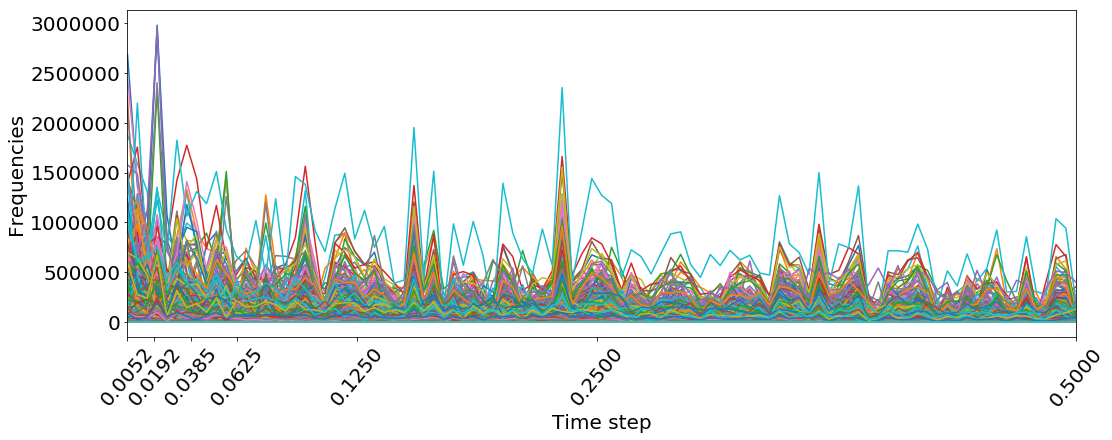

In [10]:
# Fourier Transformation
# np.fft: https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.fft.rfftfreq.html
# np.fft: https://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.rfft.html
# Power spectrum and fourier: https://stackoverflow.com/questions/15382076/plotting-power-spectrum-in-python
# Use 194 as the time step, which is station_data_dft.shape[0]
pl.figure(figsize=(17,6))
#station_fft = []
station_fft = pd.DataFrame()
data_co = []
steps = [1/194, 1/52, 1/26, 1/16, 1/8, 1/4, 1/2]
# Steps indicates the power of different periods, every 194 weeks, every year, every half year etc.  
for i in range(station_data_dft.shape[1]):
# Using fourier transformation to find out how each station swipes trends based on different time frequencies.
# Every station, FFT will score the power how it trends with time steps.
    station_fou = abs(np.fft.rfft(station_data_dft[i]))
# Using np.fft.rfftfreq to make x-axis labels based on periods testing
    x_label = np.fft.rfftfreq(station_data_dft.shape[0], 1)
    data_co.append(station_fou)
    station_fft = pd.DataFrame(data_co)
    pl.plot(x_label[1:], station_fou[1:], '-')
    #pl.xlim(1/194,1/1)
    pl.xlim(1/200,1/2)
    pl.xticks(steps, rotation=50)
    pl.ylabel('Frequencies')
    pl.xlabel('Time step')
#print(x_label)

## Caption: 
This graph shows all 600 stations' time trends prominent level based on different time steps (i.e. all 194 weeks, every year etc.). 

In [11]:
x_label
# 1/52 is 0.01923 which is between 0.01546 and 0.00206, so the x_label[3] and x_label[4] but closer to x_label[4]

array([ 0.        ,  0.00515464,  0.01030928,  0.01546392,  0.02061856,
        0.0257732 ,  0.03092784,  0.03608247,  0.04123711,  0.04639175,
        0.05154639,  0.05670103,  0.06185567,  0.06701031,  0.07216495,
        0.07731959,  0.08247423,  0.08762887,  0.09278351,  0.09793814,
        0.10309278,  0.10824742,  0.11340206,  0.1185567 ,  0.12371134,
        0.12886598,  0.13402062,  0.13917526,  0.1443299 ,  0.14948454,
        0.15463918,  0.15979381,  0.16494845,  0.17010309,  0.17525773,
        0.18041237,  0.18556701,  0.19072165,  0.19587629,  0.20103093,
        0.20618557,  0.21134021,  0.21649485,  0.22164948,  0.22680412,
        0.23195876,  0.2371134 ,  0.24226804,  0.24742268,  0.25257732,
        0.25773196,  0.2628866 ,  0.26804124,  0.27319588,  0.27835052,
        0.28350515,  0.28865979,  0.29381443,  0.29896907,  0.30412371,
        0.30927835,  0.31443299,  0.31958763,  0.32474227,  0.32989691,
        0.33505155,  0.34020619,  0.34536082,  0.35051546,  0.35

In [12]:
station_fft.describe()

,0,1,2,3,4,5,6,7,8,9,...,88,89,90,91,92,93,94,95,96,97
count,6.000000e+02,6.000000e+02,6.000000e+02,6.000000e+02,6.000000e+02,6.000000e+02,6.000000e+02,6.000000e+02,6.000000e+02,6.000000e+02,...,6.000000e+02,6.000000e+02,6.000000e+02,6.000000e+02,6.000000e+02,6.000000e+02,6.000000e+02,6.000000e+02,6.000000e+02,600.00000
mean,9.630185e+06,2.200824e+05,2.565090e+05,1.531488e+05,1.510155e+05,9.123737e+04,1.503376e+05,1.284512e+05,1.086095e+05,8.078640e+04,...,5.943066e+04,5.215044e+04,3.417141e+04,3.198894e+04,7.042279e+04,2.527540e+04,3.365063e+04,7.783329e+04,7.386770e+04,29031.52000
std,1.330312e+07,3.276256e+05,2.869978e+05,1.861240e+05,3.053491e+05,1.250618e+05,2.081186e+05,2.022696e+05,1.718975e+05,1.191356e+05,...,8.073614e+04,8.341027e+04,4.636807e+04,4.256287e+04,1.010311e+05,3.834523e+04,4.772169e+04,1.131873e+05,1.071093e+05,45685.52058
min,5.210000e+02,1.193555e-12,1.150476e-12,7.238985e-13,8.934063e-13,8.640221e-13,1.428527e-12,1.539042e-12,1.254167e-12,1.574742e-12,...,2.311481e-13,1.633928e-13,1.752114e-13,1.392379e-13,7.011219e-14,5.795156e-14,3.519564e-14,3.727412e-14,1.932986e-14,0.00000
25%,1.416244e+06,1.613544e+04,4.583511e+04,2.268443e+04,1.259810e+04,1.311366e+04,1.501545e+04,1.854789e+04,1.226364e+04,8.976385e+03,...,7.394607e+03,7.173393e+03,3.922222e+03,4.062712e+03,9.449199e+03,2.815817e+03,4.557665e+03,9.055590e+03,9.922412e+03,1567.25000
50%,5.509602e+06,1.153052e+05,1.805902e+05,9.546158e+04,6.177865e+04,5.255943e+04,7.804875e+04,6.323908e+04,5.081414e+04,4.087512e+04,...,3.150542e+04,2.725485e+04,1.995084e+04,1.794079e+04,3.553492e+04,1.293483e+04,1.750513e+04,4.026947e+04,3.845532e+04,12980.50000
75%,1.238167e+07,2.801053e+05,3.421673e+05,2.024273e+05,1.638482e+05,1.197366e+05,1.905908e+05,1.473140e+05,1.302557e+05,1.018222e+05,...,7.585322e+04,6.260769e+04,4.347919e+04,4.336259e+04,9.201453e+04,3.155444e+04,4.107353e+04,9.594732e+04,8.966710e+04,35568.75000
max,1.221067e+08,2.683783e+06,2.196921e+06,1.305792e+06,2.980185e+06,1.068946e+06,1.825638e+06,1.773493e+06,1.439180e+06,1.187358e+06,...,5.386464e+05,9.227826e+05,4.134129e+05,4.166471e+05,8.554660e+05,3.044603e+05,4.090855e+05,1.036581e+06,9.400679e+05,398894.00000


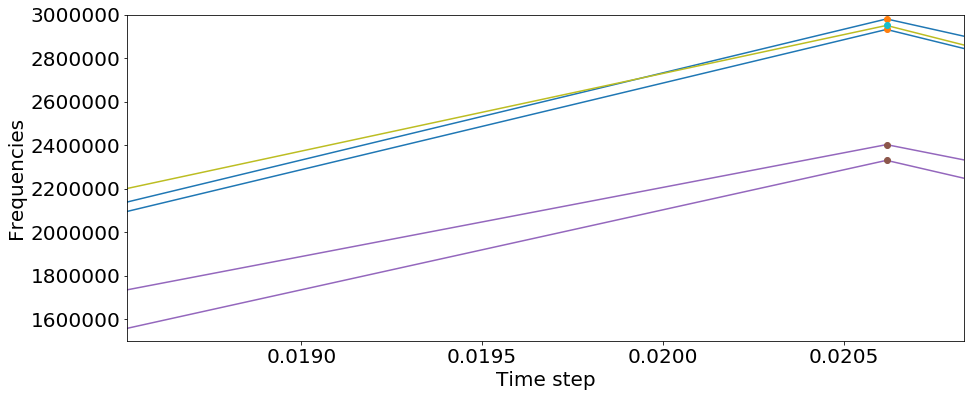

In [13]:
# 52 weeks is the period of interest. 
# Plotting the same thing but Zooming in
pl.figure(figsize=(15,6))
station_fft = pd.DataFrame()
data_co = []
steps = [1/194, 1/52, 1/26, 1/16, 1/8, 1/4, 1/2]
# Steps indicates the power of different periods, every 194 weeks, every year, every half year etc.  
for i in range(station_data_dft.shape[1]):
    station_fou = abs(np.fft.rfft(station_data_dft[i]))
    x_label = np.fft.rfftfreq(station_data_dft.shape[0], 1)
    data_co.append(station_fou)
    station_fft = pd.DataFrame(data_co)
    pl.plot(x_label[1:], station_fou[1:], '-')
    pl.plot(x_label[1:], station_fou[1:], 'o')
    #pl.xlim(1/194,1/1)
    pl.xlim(1/54,1/48)
    pl.ylim(1500000, 3000000)
    pl.ylabel('Frequencies')
    pl.xlabel('Time step')

## Caption: 
After zooming in and limit to top entries, there are five prominent but the interest will be on identifying the top 4.

In [14]:
station_fft.sort_values(by=4).tail()

,0,1,2,3,4,5,6,7,8,9,...,88,89,90,91,92,93,94,95,96,97
32,75693203.0,1.308525e+05,9.992438e+05,4.338452e+05,2.329886e+06,3.497127e+05,577719.496682,6.983788e+05,742841.154456,891148.216426,...,342668.840554,673779.117620,413412.925875,206656.591201,322275.811984,228058.190623,74175.122292,590166.754832,512742.962508,99263.0
327,6263427.0,2.834466e+05,2.641733e+05,7.632198e+05,2.402207e+06,7.097713e+05,496705.945718,8.139305e+05,618672.265212,223179.061717,...,166519.893679,216173.929435,152875.450607,230121.773286,18461.455538,183299.091924,170791.463766,62969.448402,105432.376344,206611.0
150,14799710.0,2.965563e+05,7.111031e+05,8.778044e+05,2.931882e+06,8.224251e+05,536391.081772,1.178556e+06,790293.966377,492220.906017,...,72398.875977,237900.632887,141768.712671,108459.198835,140845.645871,131623.974606,111230.694602,71721.979591,75872.705668,24618.0
194,28278674.0,4.741777e+05,6.979365e+05,1.109892e+06,2.950375e+06,7.793835e+05,392801.476995,2.995138e+04,267790.573865,260041.311124,...,275243.784825,447522.173065,204922.158508,416647.096342,377686.250317,94100.801632,341176.511043,510352.464176,492427.139776,398894.0
0,23159795.0,2.683783e+06,1.363633e+06,9.138322e+05,2.980185e+06,1.068946e+06,509333.735272,6.771447e+05,253242.690026,781881.107147,...,110641.994367,162176.395078,100661.536543,137901.728964,104011.625213,43896.041057,102267.176442,179331.988624,67072.875010,184717.0


## Result:
Station 0, 194, 150, and 327 are the top 4 (32 and 327 are very close). 

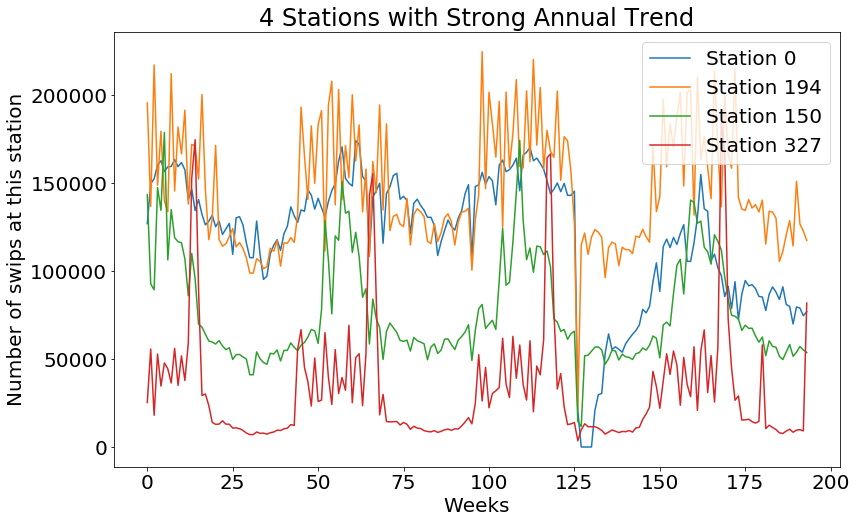

In [15]:
pl.figure(figsize=(13,8))
pl.plot(station_data_dft[0], label = 'Station 0')
pl.plot(station_data_dft[194], label = 'Station 194' )
pl.plot(station_data_dft[150], label = 'Station 150')
pl.plot(station_data_dft[327], label = 'Station 327')
pl.xlabel('Weeks')
pl.ylabel('Number of swips at this station')
pl.title('4 Stations with Strong Annual Trend')
pl.legend()

## Caption: 
The four stations plotted demonstrate the strongest annual trend. They peak at the same time. Also, they all demonstrate a drop around week 126 during Sandy. Station 328 has a very obviously period peak which might help with event identication.

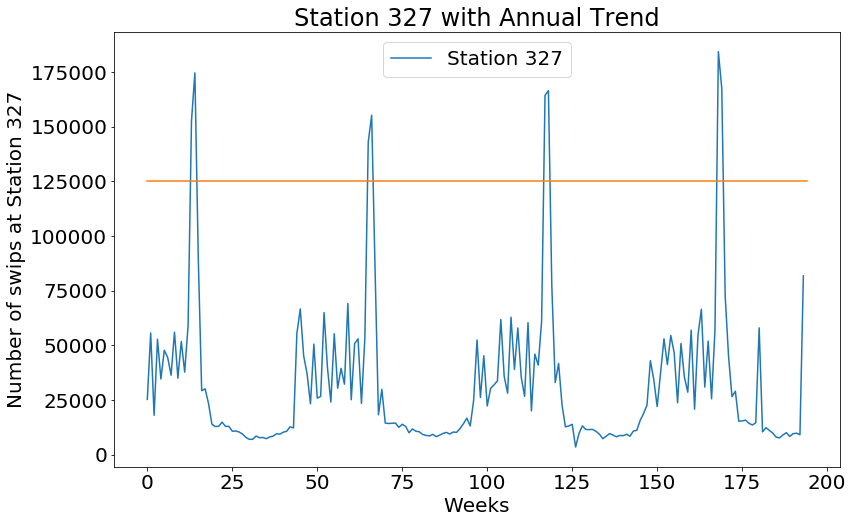

In [16]:
pl.figure(figsize=(13,8))
pl.plot(station_data_dft[327], label = 'Station 327')
pl.plot([0,194],[125000,125000], '-')
pl.xlabel('Weeks')
pl.ylabel('Number of swips at Station 327')
pl.title('Station 327 with Annual Trend')
pl.legend()

In [17]:
x = np.where(station_data_dft[327]>125000)
x

(array([ 13,  14,  65,  66, 117, 118, 168, 169]),)

## Interpretations:
Week 13 and 14 from May 21st 2010 is around the end of August 2010.
Week 65 and 66 from May 21st 2010 is around the end of August 2011.
Week 117 and 118 from May 21st 2010 is around the end of August 2012.
Week 168 and 169 from May 21st 2010 is around the end of August 2013.
The peak might be resulting from travellers coming to New York City during summer seasons are the other three stations demonstrate peak platforms around that time. 

# 4. Fourier transform
from the numpy package you will nees only the 
np.fft.rfft() to take the fourier transform

and

np.fft.rfftfreq() to create a meaningful x axis 

In [36]:
Rides_fft = np.fft.rfft(Rides_n)
Rides_fft.shape

(13800, 98)

In [33]:
n = Rides_fft.shape[0]
Ride_w = np.fft.rfftfreq(n)

In [13]:
#pl.figure(figsize=(20,10))
#pl.plot(Rides_fft)
#pl.title("All Swipes Count by stations (log10 applied)")
#pl.xlabel("Weeks since 05/21/2010")
#pl.ylabel("Number of Swipes (log10)")
